## Disclaimer
*The fia package and any results received by using the fia package are for informational and educational purposes only. You should not construe any such information or other material as
legal, tax, investment, financial, or other advice. There are risks associated with investing in any securities and assets. Do your own research. 
Past performance is not a guarantee of future return or performance. You may gain or lose money.*

# BTC analysis on CME and crypto exchanges.

Import the libraries:

In [1]:
import os


from dotenv import load_dotenv
from fia import Frame, TvDataCollector, set_logger
import pandas as pd


Set the environmental variables (Username and Password) from the .env-file (you should install python-dotenv and create the .env-file in the same folder): 

In [2]:
load_dotenv()

True

Set the logger status (optional; "INFO", "DEBUG", "WARNING", etc.)

In [3]:
set_logger("INFO")

## Collect and prepare the data from CME (BTC1! CME)

Collect the CME futures historical market data for the last five years (the month timeframe):

In [4]:
tvdc = TvDataCollector(username=os.environ.get("TV_USERNAME"),
                       password=os.environ.get("TV_PASSWORD"),
                       exchange="CME", 
                       ticker_sym="BTC1!",
                       currency="USD",
                       frame=Frame.MONTH,
                       bars=60)
raw_data = tvdc.get_data()
df_BTC_CME_month = tvdc.get_pandas_data(raw_data, tz="America/Chicago")
df_BTC_CME_month.head(5)

2023-01-25 18:43:47,106 | fia.main | INFO | The Websocket connection was created.
2023-01-25 18:43:48,568 | fia.main | INFO | All messages were created and sent. Wait...
2023-01-25 18:45:07,267 | fia.main | WARNING | The remote host closed the Websocket connection or a network error happened.
2023-01-25 18:45:07,272 | fia.main | INFO | The raw data is collected and the WebSocket connection is closed.
2023-01-25 18:45:07,275 | fia.main | INFO | The json market data was created.
2023-01-25 18:45:07,396 | fia.main | INFO | The dataframe market data was created.


,DateTime,Open,High,Low,Close,Volume
0,2018-01-31 17:00:00-06:00,10020.0,11760.0,5970.0,10645.0,22415.0
1,2018-02-28 17:00:00-06:00,10450.0,11700.0,7070.0,7335.0,43599.0
2,2018-04-01 17:00:00-05:00,6905.0,9750.0,6485.0,9365.0,59129.0
3,2018-04-30 17:00:00-05:00,9285.0,9840.0,7050.0,7545.0,72710.0
4,2018-05-31 17:00:00-05:00,7550.0,7900.0,5755.0,5865.0,53182.0


We are going to compare the data from CME with the data from crypto exchanges such as Coinbase, Gemini, Kraken, and Bitstamp. When we receive the data from Coinbase and other similar exchanges for a monthly timeframe, the historical market data includes data for every month. The last day of the month is the final point of the month. 

For example, the DateTime column has the following dates: 2018-01-31, 2018-02-28, 2018-03-31, etc.

It is possible because crypto exchanges work every day of the year. Every month has one day. 

CME does not work every day. So in some cases, the DateTime column has two values/days for the same months. One of them is for the beginning of the month. The second is for the end of the month.

For example: 2018-01-31, 2018-02-28, 2018-04-01, 2018-04-31.

As we can see, March is missed and April has 2 days (April 1 and April 31). It is obvious that date 2018-04-01 corresponds to the March market data. So we need to compensate for this time shift to compare data on CME and crypto exchanges.

Create the pandas series for that.

In [5]:
cnt_rows = df_BTC_CME_month["DateTime"].size
td = pd.Series([pd.Timedelta(5, "day") for row in range(cnt_rows)])
td.head(5)

0   5 days
1   5 days
2   5 days
3   5 days
4   5 days
dtype: timedelta64[ns]

In [6]:
df_BTC_CME_month["DateTime"] = df_BTC_CME_month["DateTime"] - td
df_BTC_CME_month.head(5)

,DateTime,Open,High,Low,Close,Volume
0,2018-01-26 17:00:00-06:00,10020.0,11760.0,5970.0,10645.0,22415.0
1,2018-02-23 17:00:00-06:00,10450.0,11700.0,7070.0,7335.0,43599.0
2,2018-03-27 17:00:00-05:00,6905.0,9750.0,6485.0,9365.0,59129.0
3,2018-04-25 17:00:00-05:00,9285.0,9840.0,7050.0,7545.0,72710.0
4,2018-05-26 17:00:00-05:00,7550.0,7900.0,5755.0,5865.0,53182.0


Create the dataframe with DateTime and Volume columns, cut/convert the date into YEAR-MONTH format.

In [7]:
volume_CME = df_BTC_CME_month.loc[:, ["DateTime", "Volume"]]
volume_CME["DateTime"] = volume_CME["DateTime"].dt.to_period("M")
volume_CME.head(5)

/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/2246683281.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_CME["DateTime"] = volume_CME["DateTime"].dt.to_period("M")


,DateTime,Volume
0,2018-01,22415.0
1,2018-02,43599.0
2,2018-03,59129.0
3,2018-04,72710.0
4,2018-05,53182.0


One bitcoin future contract size on CME is 5 BTC (see https://www.cmegroup.com/education/courses/introduction-to-bitcoin/what-are-bitcoin-futures.html). Crypto exchanges use 1 BTC as the base value. So we have to multiply the CME volume by 5. (converts future contracts to BTC)

In [8]:
volume_CME["Volume"] = volume_CME["Volume"] * 5
volume_CME.head(5)

,DateTime,Volume
0,2018-01,112075.0
1,2018-02,217995.0
2,2018-03,295645.0
3,2018-04,363550.0
4,2018-05,265910.0


## Collect and prepare the data from COINBASE, GEMINI, KRAKEN, BITSTAMP (BTC)

Collect the historical market data for the last five years (the month timeframe) from Coinbase, Gemini, Kraken, and Bitstamp. Why do we choose these 4 crypto exchanges? 
* CME uses the CME CF Bitcoin Reference Rate (BRR) (see https://www.cmegroup.com/articles/faqs/cme-cf-cryptocurrency-benchmarks-faq.html). BRR is a benchmark. 6 crypto exchanges contribute market data for CME CF cryptocurrency benchmarks: Coinbase, Gemini, Kraken, Bitstamp, ITBIT, LMAX (https://www.cmegroup.com/articles/faqs/cme-cf-cryptocurrency-benchmarks-faq.html#q14). TradingView has the access to the first four. I suppose these 4 crypto exchanges have the biggest contribution. ITBIT and LMAX can be neglected for our purpose. 
* CME uses the USD as the base currency (not USDT, USDC, etc.). 

In [9]:
exchanges = ["COINBASE", "GEMINI", "KRAKEN", "BITSTAMP"]
df_exchanges = {}
for exchange in exchanges:
    tvdc = TvDataCollector(username=os.environ.get("TV_USERNAME"),
                       password=os.environ.get("TV_PASSWORD"),
                       exchange=exchange, 
                       ticker_sym="BTCUSD",
                       currency="USD",
                       frame=Frame.MONTH,
                       bars=60)
    raw_data = tvdc.get_data()
    df_exchanges[exchange] = tvdc.get_pandas_data(raw_data, tz="America/Chicago")

2023-01-25 18:45:08,611 | fia.main | INFO | The Websocket connection was created.
2023-01-25 18:45:10,144 | fia.main | INFO | All messages were created and sent. Wait...
2023-01-25 18:46:28,772 | fia.main | WARNING | The remote host closed the Websocket connection or a network error happened.
2023-01-25 18:46:28,777 | fia.main | INFO | The raw data is collected and the WebSocket connection is closed.
2023-01-25 18:46:28,779 | fia.main | INFO | The json market data was created.
2023-01-25 18:46:28,787 | fia.main | INFO | The dataframe market data was created.
2023-01-25 18:46:29,965 | fia.main | INFO | The Websocket connection was created.
2023-01-25 18:46:31,445 | fia.main | INFO | All messages were created and sent. Wait...
2023-01-25 18:47:50,127 | fia.main | WARNING | The remote host closed the Websocket connection or a network error happened.
2023-01-25 18:47:50,132 | fia.main | INFO | The raw data is collected and the WebSocket connection is closed.
2023-01-25 18:47:50,134 | fia.m

In [10]:
df_BTC_COINBASE_month = df_exchanges["COINBASE"]
df_BTC_GEMINI_month = df_exchanges["GEMINI"]
df_BTC_KRAKEN_month = df_exchanges["KRAKEN"]
df_BTC_BITSTAMP_month = df_exchanges["BITSTAMP"]

In [11]:
df_BTC_COINBASE_month.head(5)

,DateTime,Open,High,Low,Close,Volume
0,2018-01-31 18:00:00-06:00,10099.99,11775.00,5873.0,10307.27,810577.95371
1,2018-02-28 18:00:00-06:00,10307.26,11645.74,6600.0,6928.50,590509.44348
2,2018-03-31 19:00:00-05:00,6928.50,9763.49,6450.0,9243.83,397828.58622
3,2018-04-30 19:00:00-05:00,9243.83,9948.12,7058.0,7485.00,279347.22025
4,2018-05-31 19:00:00-05:00,7485.00,7777.00,5777.0,6383.19,242099.65644


Create the dataframes with DateTime and Volume columns, cut/convert the date into YEAR-MONTH format:

In [12]:
volume_exchanges = {}
for exchange in exchanges:
    volume_exchange = (df_exchanges[exchange].loc[:, ["DateTime", "Volume"]])
    volume_exchange["DateTime"] = volume_exchange["DateTime"].dt.to_period("M")
    volume_exchanges[exchange] = volume_exchange.set_index("DateTime")
volume_exchanges["COINBASE"].head(5)    

/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/264568657.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_exchange["DateTime"] = volume_exchange["DateTime"].dt.to_period("M")
/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/264568657.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_exchange["DateTime"] = volume_exchange["DateTime"].dt.to_period("M")
/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/264568657.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_exchange["DateTime"] = volume_exchange["DateTime"].dt.to_period("M")
/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/264568657.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_exchange["DateTime"] = volume_exchange["DateTime"].dt.to_period("

,Volume
DateTime,
2018-01,810577.95371
2018-02,590509.44348
2018-03,397828.58622
2018-04,279347.22025
2018-05,242099.65644


In [13]:
df_COINBASE_volume_month = volume_exchanges["COINBASE"]
df_GEMINI_volume_month = volume_exchanges["GEMINI"]
df_KRAKEN_volume_month = volume_exchanges["KRAKEN"]
df_BITSTAMP_volume_month = volume_exchanges["BITSTAMP"]
df_COINBASE_volume_month.head(5)

,Volume
DateTime,
2018-01,810577.95371
2018-02,590509.44348
2018-03,397828.58622
2018-04,279347.22025
2018-05,242099.65644


## Collect and prepare the data from BINANCE (BTC/USDT, spot)

Collect the Binance historical market data (the month timeframe):

In [14]:
tvdc = TvDataCollector(username=os.environ.get("TV_USERNAME"),
                       password=os.environ.get("TV_PASSWORD"),
                       exchange="BINANCE", 
                       ticker_sym="BTCUSDT",
                       currency="USD",
                       frame=Frame.MONTH,
                       bars=60)
raw_data = tvdc.get_data()
df_BTC_BINANCE_month = tvdc.get_pandas_data(raw_data, tz="America/Chicago")
df_BTC_BINANCE_month.head(5)

2023-01-25 18:50:33,930 | fia.main | INFO | The Websocket connection was created.
2023-01-25 18:50:35,399 | fia.main | INFO | All messages were created and sent. Wait...
2023-01-25 18:51:54,093 | fia.main | WARNING | The remote host closed the Websocket connection or a network error happened.
2023-01-25 18:51:54,099 | fia.main | INFO | The raw data is collected and the WebSocket connection is closed.
2023-01-25 18:51:54,101 | fia.main | INFO | The json market data was created.
2023-01-25 18:51:54,126 | fia.main | INFO | The dataframe market data was created.


,DateTime,Open,High,Low,Close,Volume
0,2021-05-31 19:00:00-05:00,37268.721528,41346.5320,28816.522000,35059.018000,2.901775e+06
1,2021-06-30 19:00:00-05:00,35052.009000,42456.4896,29283.855600,41470.122366,1.778463e+06
2,2021-07-31 19:00:00-05:00,41486.717104,50530.3000,37355.099620,47129.150534,1.635403e+06
3,2021-08-31 19:00:00-05:00,47110.310178,52930.5840,39607.920000,43832.864820,1.527800e+06
4,2021-09-30 19:00:00-05:00,43828.774002,67013.4000,43291.686606,61312.059960,1.565547e+06


Create the dataframe with DateTime and Volume column, cut/convert the date into YEAR-MONTH format:

In [15]:
volume_BINANCE = df_BTC_BINANCE_month.loc[:, ["DateTime", "Volume"]]
volume_BINANCE["DateTime"] = volume_BINANCE["DateTime"].dt.to_period("M")
volume_BINANCE = volume_BINANCE.set_index("DateTime")
volume_BINANCE.head(5)    

/var/folders/gh/mx3xbl0d69jftpptc8yn6mn40000gn/T/ipykernel_29836/3641663784.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  volume_BINANCE["DateTime"] = volume_BINANCE["DateTime"].dt.to_period("M")


,Volume
DateTime,
2021-05,2.901775e+06
2021-06,1.778463e+06
2021-07,1.635403e+06
2021-08,1.527800e+06
2021-09,1.565547e+06


## Compare the CME futures volume with the crypto exchanges volume (Coinbase, Geimini, Kraken, Bitstamp)

Concatinate the volume data from 5 exchanges:

In [16]:
df = pd.concat(
    [
        volume_CME.set_index("DateTime"),
        volume_exchanges["COINBASE"], 
        volume_exchanges["GEMINI"], 
        volume_exchanges["KRAKEN"], 
        volume_exchanges["BITSTAMP"]        
    ],  
    axis=1,
    join="inner"
)
df.columns = [ "Volume_CME", "Volume_COINBASE", "Volume_GEMINI", "Volume_KRAKEN", "Volume_BITSTAMP" ]
df.head(5)

,Volume_CME,Volume_COINBASE,Volume_GEMINI,Volume_KRAKEN,Volume_BITSTAMP
DateTime,,,,,
2018-01,112075.0,810577.95371,270765.118818,307288.817425,579336.186375
2018-02,217995.0,590509.44348,219405.454856,357081.409426,477981.404561
2018-03,295645.0,397828.58622,146603.284382,216892.033102,382811.764112
2018-04,363550.0,279347.22025,110978.291788,133683.161950,315307.615853
2018-05,265910.0,242099.65644,84948.960548,118024.334767,244681.794212


Set and create the plot (stacked bar chart):

In [17]:
df = df.reset_index()

<AxesSubplot: title={'center': 'Montly BTC Volume on CME Futures and COINBASE, GEMINI, KRAKEN and BITSTAMP exchanges (spot, BTCUSD).'}, xlabel='Date (Year-Month)', ylabel='Volume, BTC'>

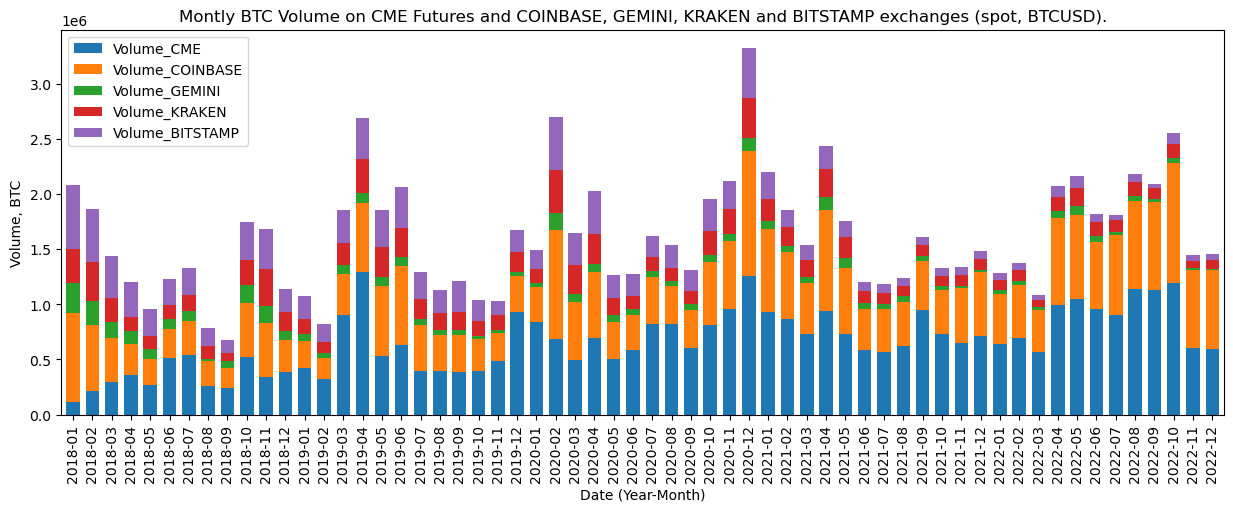

In [18]:
df.plot(
    x="DateTime", 
    kind="bar", 
    stacked=True,
    # grid="on",
    figsize=(15, 5),
    width=0.7,
    xlabel="Date (Year-Month)",
    ylabel="Volume, BTC",
    title="Montly BTC Volume on CME Futures and COINBASE, GEMINI, KRAKEN and BITSTAMP exchanges (spot, BTCUSD)."
)

## Compare the CME futures volume with the Binance volume (spot)

In [19]:
df = pd.concat(
    [
        volume_CME.set_index("DateTime"),
        volume_BINANCE
    ],
    axis=1,
    join="inner"
)
df.columns = ["Volume_CME", "Volume_BINANCE"]
df.head(5)

,Volume_CME,Volume_BINANCE
DateTime,,
2021-05,727070.0,2.901775e+06
2021-06,584010.0,1.778463e+06
2021-07,564555.0,1.635403e+06
2021-08,622350.0,1.527800e+06
2021-09,944830.0,1.565547e+06


Set and create the plot (stacked bar chart):

In [20]:
df = df.reset_index()

<AxesSubplot: title={'center': 'Montly BTC Volume on CME Futures and BINANCE (spot, BTCUSDT).'}, xlabel='Date (Year-Month)', ylabel='Volume, BTC'>

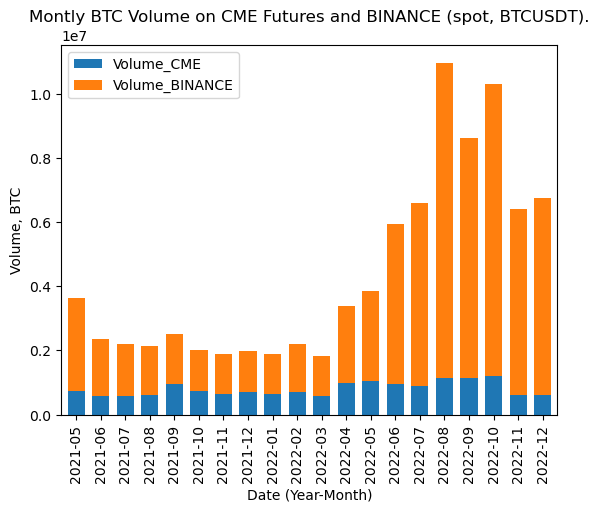

In [21]:
df.plot(
    x="DateTime", 
    kind="bar", 
    stacked=True,
    # grid="on",
    #figsize=(15, 5),
    width=0.7,
    xlabel="Date (Year-Month)",
    ylabel="Volume, BTC",
    title="Montly BTC Volume on CME Futures and BINANCE (spot, BTCUSDT)."
)

## Conclusion

* On the one hand, CME has a significant portion of total trading volume (~40-50% of BTC/USD market), especially in the last 2 years.
* On the other hand, even one Binance has a much bigger volume than CME. If we add volumes of other crypto exchanges (Bybit, OKX, MEXC, etc.), perpetual futures (not only spot market), and trading pairs with other stablecoins (BUSD, USDC, etc.), the difference in the volume will be even bigger.  
* Nevertheless CME is used by big institutional investors and funds, so the CME volume can influence the market. 
* It is important to estimate the weekend gaps as one of the factors that can influence the market.

## Useful links

* https://www.cmegroup.com/articles/faqs/cme-cf-cryptocurrency-benchmarks-faq.html
* https://www.cmegroup.com/education/articles-and-reports/analysis-of-cme-cf-bitcoin-reference-rate.html
* https://www.cmegroup.com/education/courses/introduction-to-cryptocurrency-futures/bitcoin/introduction-to-bitcoin-reference-rate.html
* https://www.cmegroup.com/education/courses/introduction-to-bitcoin/what-are-bitcoin-futures.html
* https://www.cmegroup.com/markets/cryptocurrencies/bitcoin/bitcoin.contractSpecs.html
* https://www.cmegroup.com/markets/cryptocurrencies/bitcoin/bitcoin.volume.html
* https://blockworks.co/news/bitcoin-futures-and-short-etfs-record-huge-volume-spike-tuesday
* https://www.forbes.com/sites/javierpaz/2022/08/26/more-than-half-of-all-bitcoin-trades-are-fake
* https://www.forbes.com/sites/javierpaz/2022/03/16/the-best-global-crypto-exchanges